# <span style="color:blue">  Movie Tweetings PySpark Recommender</span>


From the November 27th tweetings avaliable, the ratings and items data files will be loaded first into pandas and then converted to Spark dataframes. Both versions will be used for analysis and visualization purposes. 



In [1]:
import findspark
findspark.init('/usr/local/opt/apache-spark/libexec')
from pyspark import SparkContext
import pyspark
import pandas as pd

sc = pyspark.SparkContext(appName="spark based notebook")

#print sc


In [2]:
pdmovies = pd.read_csv('movies.dat', sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
pdmovies = pdmovies.drop('Genres', 1)
pdmovies[['movie', 'year']] = pdmovies['Movie_Title'].str.split('(',expand=True)
pdmovies[['year', 'del']] = pdmovies['year'].str.split(')',expand=True)
pdmovies = pdmovies.drop('del', 1)
pdmovies = pdmovies.drop('Movie_Title', 1)
pdratings = pd.read_csv('ratings.dat', sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
pdratings=pdratings.drop('Timestamp',1)

/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [3]:
import numpy as np
pdratings=pdratings.merge(pdmovies,on='MovieId',how='left')
pdratings["scaled"] = np.sign(pdratings.Rating - 5)
#print(pdmovies)
print(pdratings)

        UserId  MovieId  Rating                                movie  year  \
0            1    68646      10                       The Godfather   1972   
1            1   113277      10                                Heat   1995   
2            2   422720       8                    Marie Antoinette   2006   
3            2   454876       8                          Life of Pi   2012   
4            2   790636       7                  Dallas Buyers Club   2013   
5            2   816711       8                         World War Z   2013   
6            2  1091191       7                       Lone Survivor   2013   
7            2  1103275       7                          Two Lovers   2008   
8            2  1322269       7                August: Osage County   2013   
9            2  1390411       8             In the Heart of the Sea   2015   
10           2  1398426       8              Straight Outta Compton   2015   
11           2  1431045       7                            Deadp

The pandas dataframes are now converted to Spark dataframes using SQL Context.

In [4]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
ratings=sqlCtx.createDataFrame(pdratings)


# Exploratory Analysis & Visualization of Data

In [5]:
ratings.describe().show()

+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|summary|            UserId|           MovieId|           Rating|    movie|              year|            scaled|
+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|  count|            661041|            661041|           661041|   661041|            661041|            661041|
|   mean|25746.769123246515|1682644.1942859823|7.301606103101018| Infinity|2008.3000766972093|0.7817381977819833|
| stddev|14790.731994397118| 1261723.933614962|1.861220224723241|      NaN|12.648961199287482|0.5618353337379685|
|    min|                 1|                 8|                0|       $ |              1878|                -1|
|    max|             51713|           7659376|               10|Ãrestir |              2017|                 1|
+-------+------------------+------------------+-----------------+---------+-------------

In [6]:


print "Number of different users: " + str(ratings.select('userId').distinct().count())
print "Number of different movies: " + str(ratings.select('movieId').distinct().count())
print "Number of movies with at least one rating strictly less than 5: " + str(ratings.filter('rating < 5').select('movieId').distinct().count())
print "Number of movies with at least one rating 5 or greater : " + str(ratings.filter('rating >= 5').select('movieId').distinct().count())



Number of different users: 51713
Number of different movies: 29733
Number of movies with at least one rating strictly less than 5: 10230
Number of movies with at least one rating 5 or greater : 27234


In particular, we lack here a substantial number of ratings for items that are disliked by our users. This intuitively makes sense. Users may prefer to share their movie rating through Twitter if they enjoyed watching the film to allow their followers to know about a great movie. 


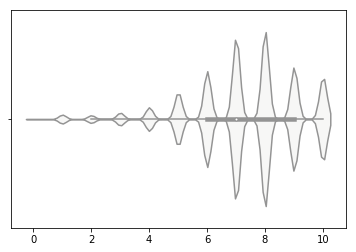

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.violinplot([pdratings.Rating],palette='PiYG')

We see here again that users tend to tweet structured tweets about movies they rate highly.

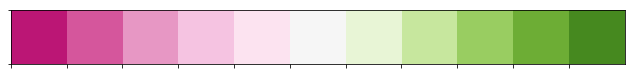

In [80]:
sns.palplot(sns.color_palette("PiYG", 11))


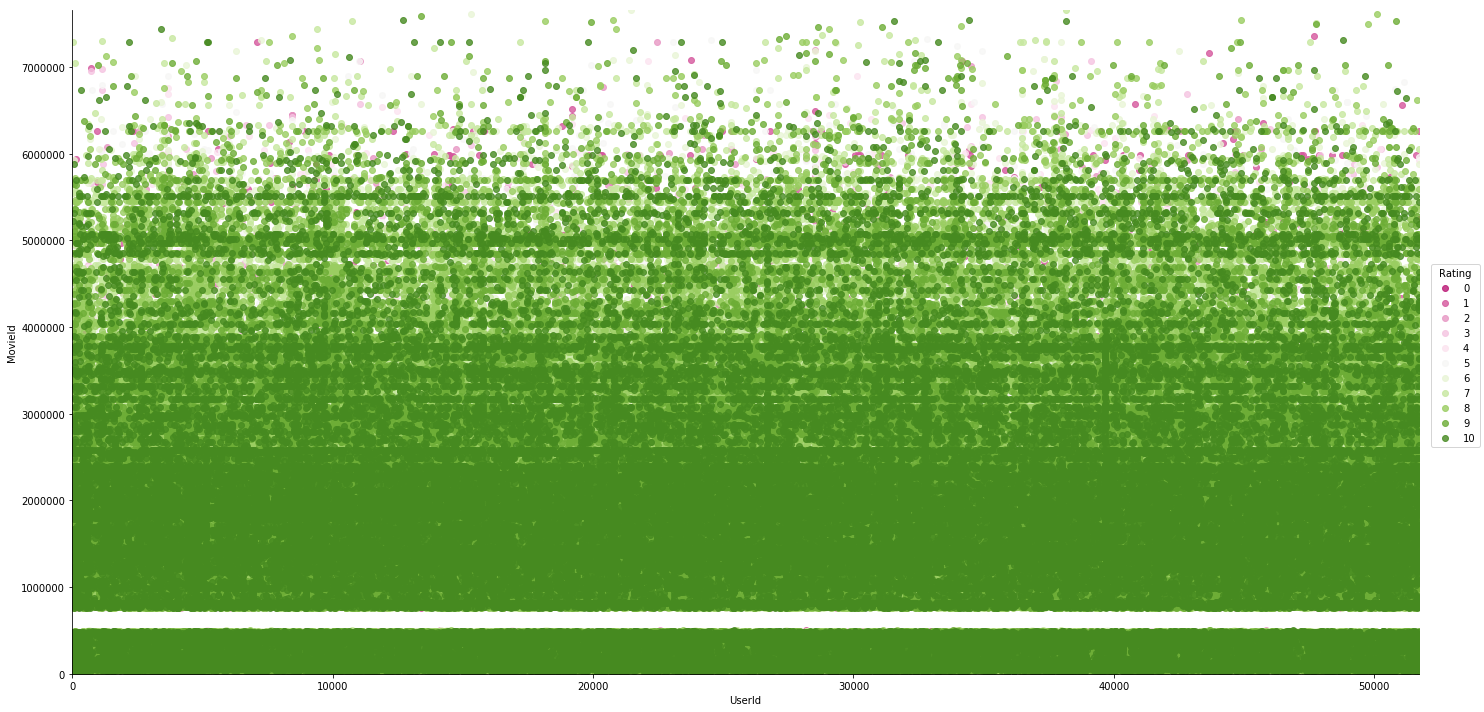

In [29]:


visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=pdratings, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

# <span style="color:green">  Implicit Feedback Model v Explicit Ratings Model</span>

Assuming that the asymmetric nature of the ratings distribution arises because of an analog of voluntary response bias, or rather in this case voluntary tweet bias, we can test the ALS model when ratings are considered as an explicit rating versus whether this provides implicit feedback representing strength of opinion. 

# Implicit Feedback Model

The data is initially split into 80% training data and 20% test data. 

In [6]:
from pyspark.ml.recommendation import ALS
(trainingRatings, testRatings) = ratings.randomSplit([80.0, 20.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating",implicitPrefs=True,coldStartStrategy="drop")

ALSimplmodel = als.fit(trainingRatings)

In [7]:
imppredictions = ALSimplmodel.transform(testRatings)
imppredictions.show()

+------+-------+------+--------------------+----+------+------------+
|UserId|MovieId|Rating|               movie|year|scaled|  prediction|
+------+-------+------+--------------------+----+------+------------+
| 25309|  46521|     8|        I vitelloni |1953|     1|  0.14190397|
| 14606|  46521|     8|        I vitelloni |1953|     1|  0.06643961|
| 23899|  46521|     8|        I vitelloni |1953|     1|  0.14762239|
| 11470|  46521|     8|        I vitelloni |1953|     1|  0.16560207|
| 29270|  46521|     8|        I vitelloni |1953|     1|  0.01876222|
| 49847|  46521|    10|        I vitelloni |1953|     1| 0.009763715|
| 19108|  48254|     8|      Killer's Kiss |1955|     1| 0.012963679|
| 15042|  57693|     5|                  X |1963|     0|-3.253201E-4|
| 37338|  64519|     5|      DoppelgÃ¤nger |1969|     0| 0.026405962|
| 41675|  64519|     5|      DoppelgÃ¤nger |1969|     0| 0.036851913|
| 33578|  70355|    10|       Magnum Force |1973|     1| 0.005532432|
| 41151|  72820|    

In [61]:
#imppredictions.describe().show()


In [8]:
imp=imppredictions.toPandas()
imp=imp.sort_values(by=['UserId', 'prediction'],ascending=False)

In [13]:
implicit_by_pred=imp.groupby('UserId').head(3).reset_index(drop=True)

In [21]:
imp=imp.sort_values(by=['UserId', 'Rating'],ascending=False)
implicit_by_rating=imp.groupby('UserId').head(3).reset_index(drop=True)

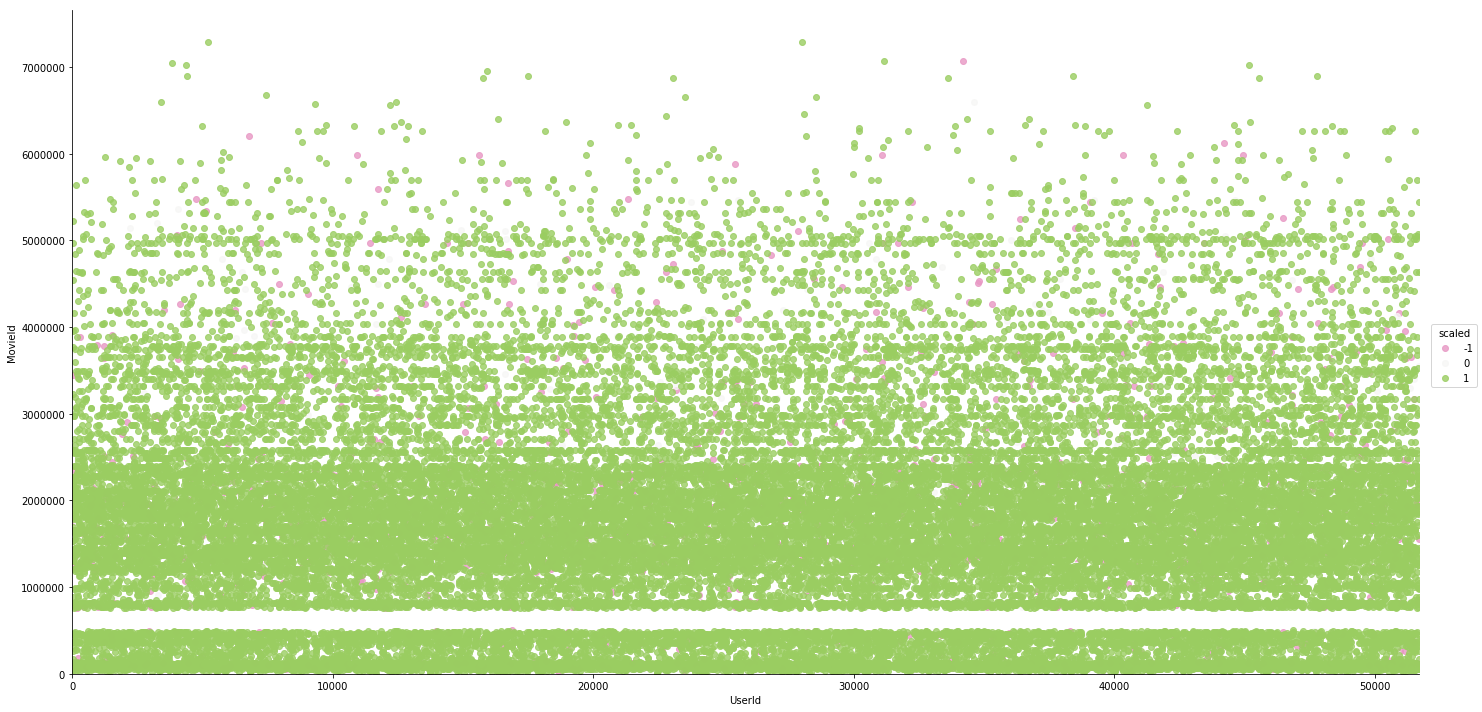

In [19]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='scaled', data=implicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 3),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

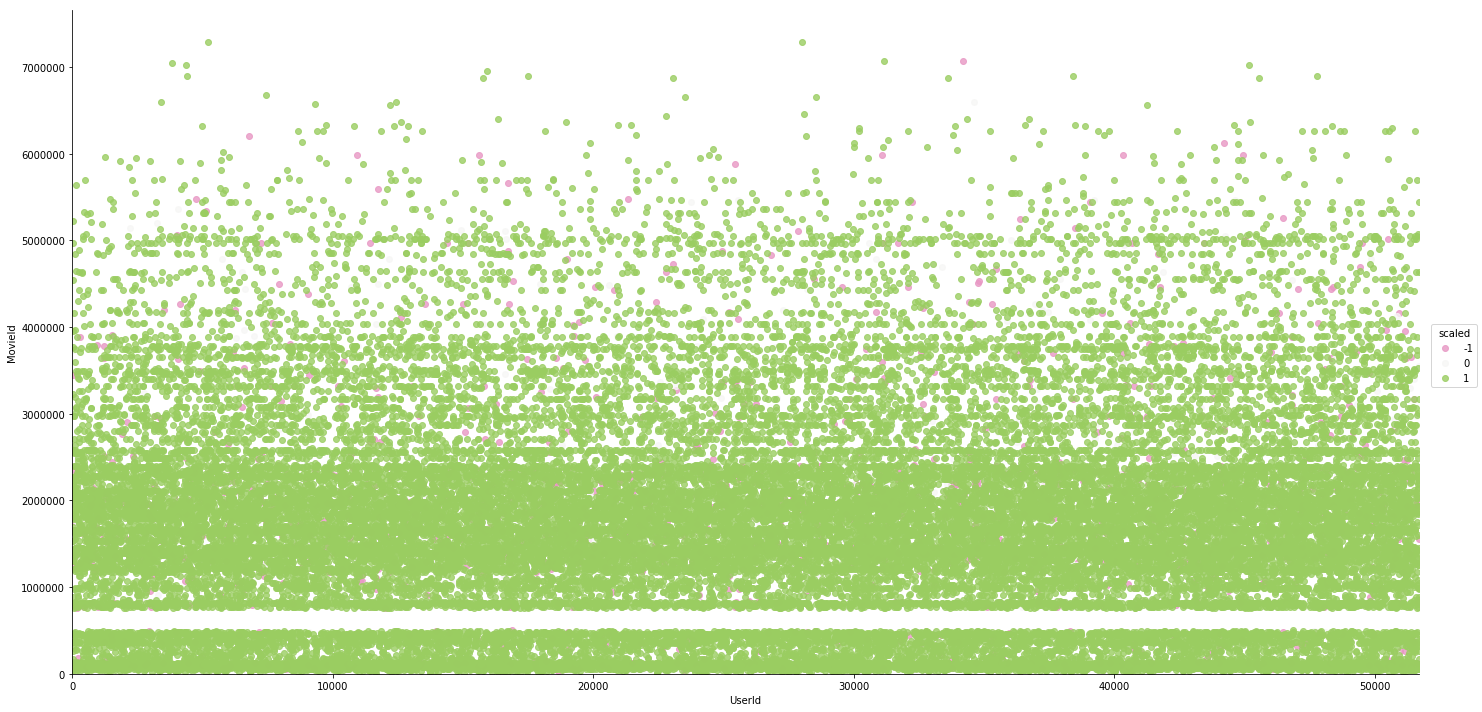

In [20]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='scaled', data=implicit_by_rating, size=10, aspect=2, palette=sns.color_palette("PiYG", 3),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

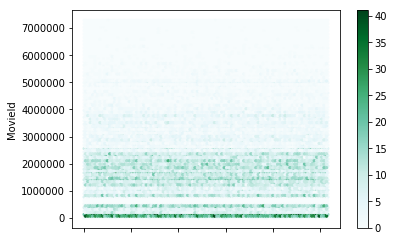

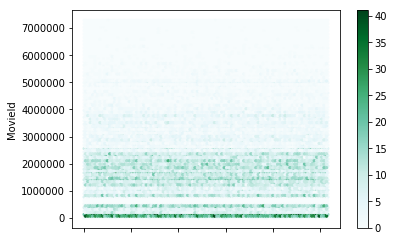

In [45]:
import numpy as np
import pylab as plt

#plt.scatter(UserId,MovieId,data=implicit_by_rating,color='k')
#plt.scatter(X,Y2,color='g')
#plt.show()

implicit_by_pred.plot(kind='hexbin', x='UserId', y='MovieId')
implicit_by_rating.plot(kind='hexbin', x='UserId', y='MovieId')

The graph above shows that this implicit feedback model has both poor precision and recall because a given prediction value relates to both liked and disliked movies in both the scaled sense and in the explicit rating sense. Therefore, we will continue to now exploring the explicit ratings model.

# Explicit Ratings Model

In [25]:

(trainingRatings, testRatings) = ratings.randomSplit([90.0, 10.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating")
ALSmodel = als.fit(trainingRatings)

In [26]:
predictions = ALSmodel.transform(testRatings)
predictions.show()

+------+-------+------+--------------------+----+------+----------+
|UserId|MovieId|Rating|               movie|year|scaled|prediction|
+------+-------+------+--------------------+----+------+----------+
|  9574|  18051|     9|    The Kid Brother |1927|     1| 5.8693175|
| 38084|  43852|     7| Night Into Morning |1951|     1|       NaN|
| 32098|  46521|     8|        I vitelloni |1953|     1|  8.062614|
|  7783|  46521|     8|        I vitelloni |1953|     1|  6.570483|
| 48017|  58305|    10|The Luck of Ginge...|1964|     1|       NaN|
| 37338|  64519|     5|      DoppelgÃ¤nger |1969|     0| 4.0246186|
| 32397|  64519|     4|      DoppelgÃ¤nger |1969|    -1|  3.978585|
|  5056|  65408|     8|  Anonimo veneziano |1970|     1|       NaN|
|  9062|  69048|     6|Gli orrori del ca...|1972|     1|       NaN|
| 37964|  72820|     4|        Cooley High |1975|    -1|  6.763186|
|  3675|  83250|     4|Un dimanche de flic |1983|    -1|       NaN|
| 14289|  86927|     5|     Bachelor Party |1984

In [27]:
exp=predictions.toPandas()
exp=exp.sort_values(by=['UserId', 'prediction'],ascending=False)
explicit_by_pred=exp.groupby('UserId').head(3).reset_index(drop=True)

In [28]:
exp=exp.sort_values(by=['UserId', 'Rating'],ascending=False)
explicit_by_rating=exp.groupby('UserId').head(3).reset_index(drop=True)

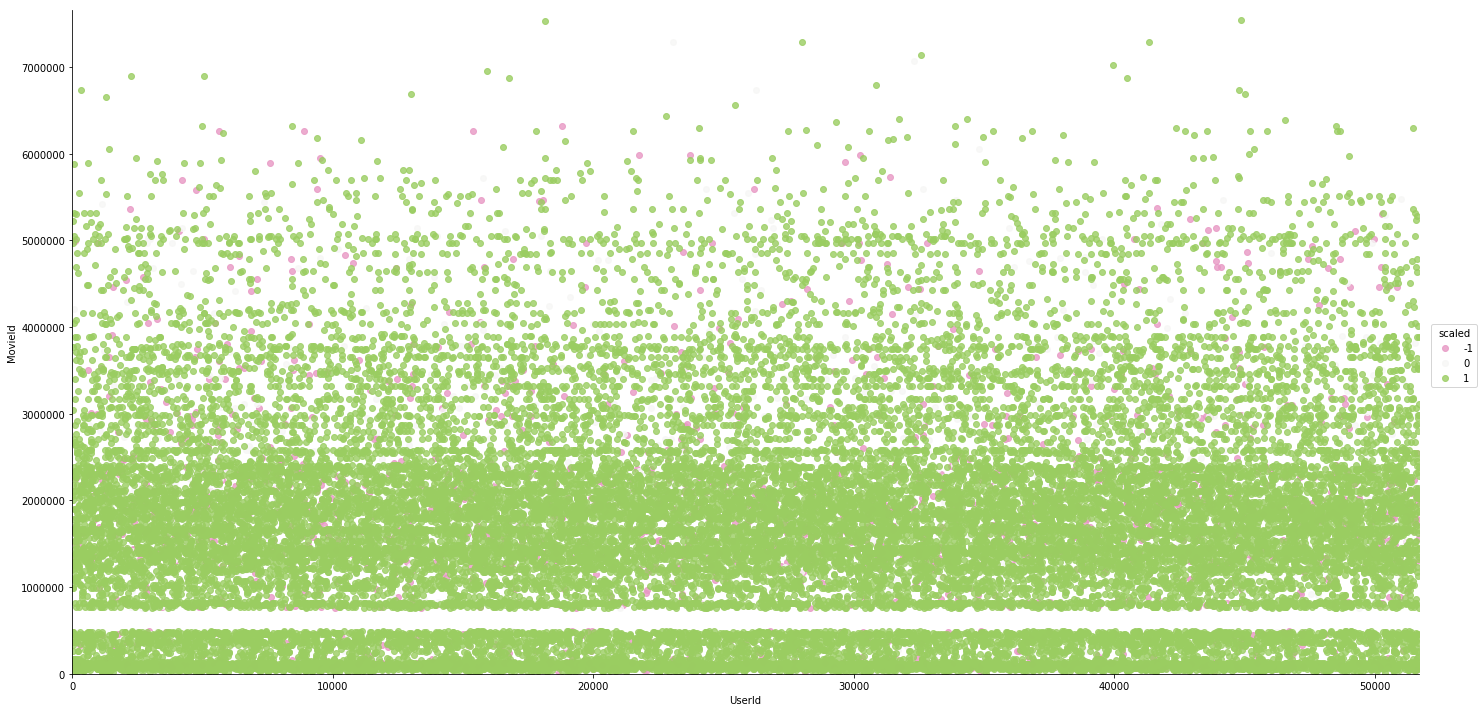

In [29]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='scaled', data=explicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 3),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

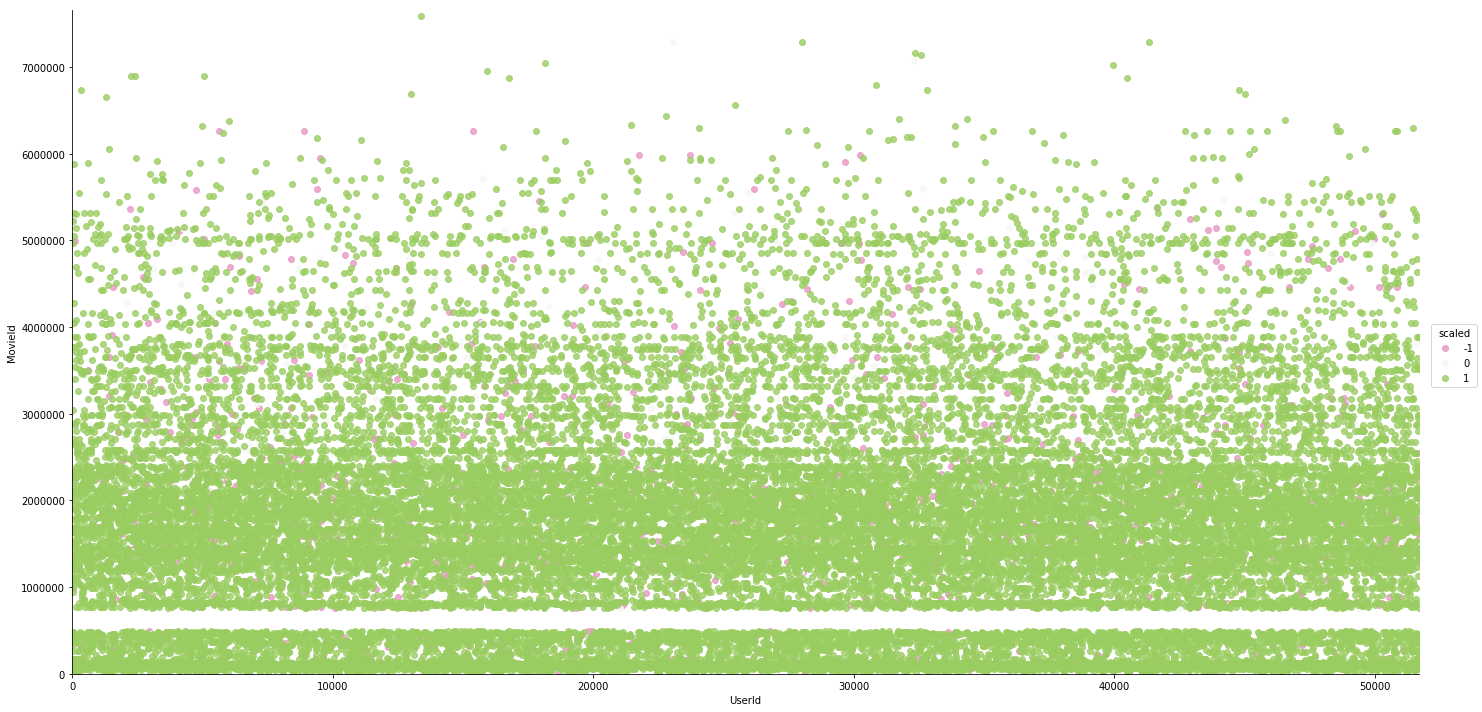

In [30]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='scaled', data=explicit_by_rating, size=10, aspect=2, palette=sns.color_palette("PiYG", 3),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

In [64]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions))

The root mean squared error for the model is: nan


NaN results because the ALS model cannot predict ratings for users who have no ratings which is also known as the Cold Start problem. In this business case scenario we would still wish to predict recommendations for that user. Therefore, we elect to replace NaN values with the average rating and evaluate the model.

In [65]:
average = ratings.select('rating').groupBy().avg().first()[0]
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions.na.fill(average))) 


The root mean squared error for the model is: 1.65887154941


# Tuning Hyperparamters for Explicit Ratings Model: Rank & the Regularization Parameter

The following hyperparamter modeling is computationally costly. A grid of parameter combinations is created a grid search is run over these respective combinations to compare their performance. The resulting model has an RMSE that is greater than the model above. 
Note: Because this is computationally costly, it may take several minutes to run.

In [44]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = ratings.randomSplit([90.0, 10.0])
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [5, 10])\
            .addGrid(als.maxIter, [25])\
            .addGrid(als.regParam, [0.05, 0.1, 0.5])\
            .build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(average)))

The root mean squared error for our model is: 1.70177583308


The RMSE here is greater than that of the default ALS model: rank=10, maxIter=10, regParam=0.1. 